# Capstone Evaluation

In this notebook, I will build upon the work I have done in the "USING DATA TO PREDICT HUMAN LONGEVITY" project.  
All the data has been looked at and cleaned. Multiple models have been trained.  
In this notebook, I will use the data to ask more questions and come to more conclusions.  
The first thing I need to do, is load the data and clean it.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np

In [29]:
life_data = pd.read_csv("Life Expectancy Data.csv")

In [21]:
life_data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [30]:
life_data = life_data.dropna()

In [34]:
bin_edges = [0, 55, 65, 75, float('inf')]
bin_labels = ['0 - 55', '55 - 65', '65 - 75', '75 and above']
life_data_categorical = life_data.copy()
life_data_categorical['Life expectancy '] = pd.cut(life_data_categorical['Life expectancy '], bins=bin_edges, labels=bin_labels, right=False)

**FIRST QUESTION: What is the difference in longevity in developing countries vs developed countries?**

To answer this question, I first need to make the right datasets.

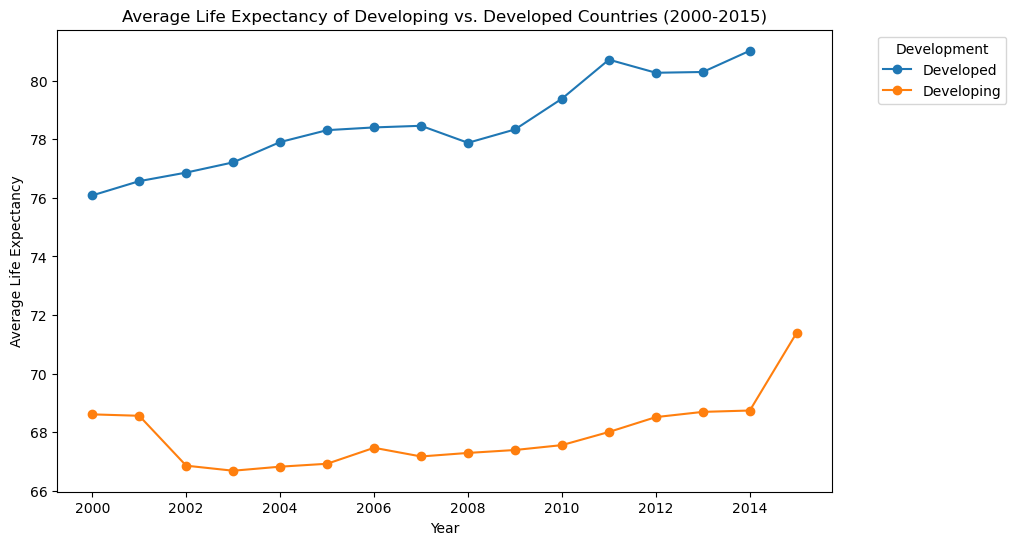

In [23]:
grouped_data = life_data.groupby(['Year', 'Status'])['Life expectancy '].mean().reset_index()
pivot_data = grouped_data.pivot(index='Year', columns='Status', values='Life expectancy ')
pivot_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average Life Expectancy of Developing vs. Developed Countries (2000-2015)')
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')
plt.legend(title='Development', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

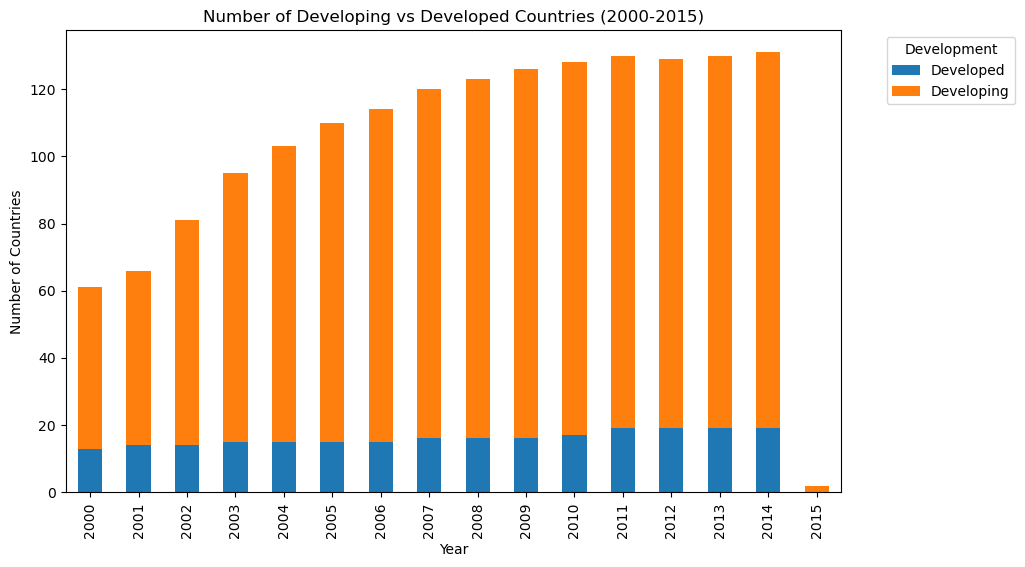

In [24]:
count_by_year = life_data.groupby(['Year', 'Status']).size().unstack()
count_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Developing vs Developed Countries (2000-2015)')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.legend(title='Development', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Answer 1:**  
These two graphs show us that over the years, the life expectancy in both developed and developing countries has steadily  
although the number of developed countries has very slightly increased over the years.  
The difference in longevity between the two types of countries is still 8 years in the year 2015.

**SECOND QUESTION:** What factors affect longevity in developed countries vs developing countries.

To answer this question, I first need to make the appropriate datasets.

In [35]:
developed_countries = life_data_categorical[life_data_categorical['Status'] == 'Developed']
y_developed = developed_countries['Life expectancy ']
developed_countries = developed_countries.drop(['Life expectancy ', 'Year', 'Country', 'Status'], axis = 1)
developing_countries = life_data_categorical[life_data_categorical['Status'] == 'Developing']
y_developing = developing_countries['Life expectancy ']
developing_countries = developing_countries.drop(['Life expectancy ', 'Year', 'Country', 'Status'], axis = 1)

Now that I have the required datasets, I will run an algorithm that checks which factors affect longevity the most.

In [40]:
#Calculating most important factors for developing countries
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(developing_countries, y_developing)
feature_importances = rf_classifier.feature_importances_
feature_importance_results = pd.DataFrame({'Feature': developing_countries.columns, 'Importance': feature_importances})
feature_importance_results.sort_values(by='Importance', ascending=False, inplace=True)

# Display the results
print(feature_importance_results)

                            Feature  Importance
0                   Adult Mortality    0.203618
16  Income composition of resources    0.144041
11                         HIV/AIDS    0.115599
17                        Schooling    0.082858
15               thinness 5-9 years    0.058303
14             thinness  1-19 years    0.047605
3            percentage expenditure    0.040907
2                           Alcohol    0.040429
6                              BMI     0.040025
9                 Total expenditure    0.036999
7                under-five deaths     0.036806
12                              GDP    0.035082
1                     infant deaths    0.025652
13                       Population    0.022590
8                             Polio    0.019340
10                      Diphtheria     0.018653
4                       Hepatitis B    0.016541
5                          Measles     0.014954


In [39]:
#Calculating most important factors for developed countries
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(developed_countries, y_developed)
feature_importances = rf_classifier.feature_importances_
feature_importance_results = pd.DataFrame({'Feature': developing_countries.columns, 'Importance': feature_importances})
feature_importance_results.sort_values(by='Importance', ascending=False, inplace=True)

# Display the results
print(feature_importance_results)

                            Feature  Importance
14             thinness  1-19 years    0.229261
0                   Adult Mortality    0.181883
15               thinness 5-9 years    0.174558
16  Income composition of resources    0.096735
9                 Total expenditure    0.054385
3            percentage expenditure    0.042068
10                      Diphtheria     0.038452
17                        Schooling    0.033854
8                             Polio    0.026112
12                              GDP    0.025040
4                       Hepatitis B    0.021839
2                           Alcohol    0.021371
13                       Population    0.016030
6                              BMI     0.012421
7                under-five deaths     0.010780
1                     infant deaths    0.007938
5                          Measles     0.007271
11                         HIV/AIDS    0.000000


**Answer 2:**  
Funnily enough, the most important factor that affects longevity in developed countries is 'thinness  1-19 years'.
The second most important feature is 'thinness 5-9 years'. An abundance of resources in developed countries is affecting the longevity of the population.  
For developing countries on the other hand, income and HIV/AIDS are the two biggest features that affect longevity while thinness are fourth and fifth place.  
HIV/AIDS come in last place in developed countries. This is likely due to better access to medicine.

**Using Models to Make a Prediction**

We know the best model for predictions is the decision tree. Let's train a decision tree again and test it on new data points.  
We already know the best max_depth for this data is 10.

The reason decision trees work the best has been discussed in the previous notebbok.

In [44]:
depths = []
DT_accuracy = []
X = life_data_categorical.drop(['Life expectancy ', 'Year', 'Country', 'Status'], axis = 1)
y = life_data_categorical['Life expectancy ']
for max_depth in range(1, 20):
    depths.append(max_depth)
    dt_model = DecisionTreeClassifier(max_depth = 10, random_state=42)
    dt_model.fit(X, y)

In [59]:
test_data = pd.DataFrame({'Adult Mortality': [100, 200, 300], 'infant deaths': [30, 40, 50], 'Alcohol': [10, 30, 50], 'percentage expenditure': [75, 50, 25], 'Hepatitis B': [65, 20, 35], 'Measles ': [324, 654, 564], ' BMI ': [20, 25, 30],'under-five deaths ':[23, 54, 76], 'Polio': [45, 23, 67], 'Total expenditure': [8, 10, 12], 'Diphtheria ': [10, 20, 30], ' HIV/AIDS': [0.1, 0.1, 0.1], 'GDP': [589, 3234, 2332], 'Population': [32424324, 234234243, 234234234], ' thinness  1-19 years': [17, 20, 30], ' thinness 5-9 years': [17, 20, 30], 'Income composition of resources': [0.7, 0.5, 0.3], 'Schooling': [10, 15, 20]})
y_pred = dt_model.predict(test_data)

Now that we have trained the model, let's make some completely new test data points.  
I have made three test cases. Here they are:  
'Adult Mortality':  &emsp;[100, 200, 300]  
'infant deaths':  &emsp;[30, 40, 50]  
'Alcohol': &emsp;[10, 30, 50]  
'percentage expenditure': &emsp;[75, 50, 25]  
'Hepatitis B': &emsp;[65, 20, 35]  
'Measles ': &emsp;[324, 654, 564]  
' BMI ': &emsp;[20, 25, 30]  
'under-five deaths ':    &emsp;[23, 54, 76]   
'Polio':  &emsp;(45, 23, 67)  
'Total expenditure': &emsp;[8, 10, 12]  
'Diphtheria ': &emsp;[10, 20, 30]  
' HIV/AIDS': &emsp;[0.1, 0.1, 0.1]  
'GDP': &emsp;[589, 3234, 2332]   
'Population': &emsp;[32424324, 234234243, 234234234]  
' thinness  1-19 years': &emsp;[17, 20, 30]  
' thinness 5-9 years': &emsp;[17, 20, 30]  
'Income composition of resources': &emsp;[0.7, 0.5, 0.3]  
'Schooling': &emsp;[10, 15, 20]  

Let's look at the predictions the trained DecisionTree has made:


In [60]:
print(y_pred)

['65 - 75' '75 and above' '55 - 65']


The trained DecisionTree model has made three different predictions for the three test cases. Similarly, an insurance company  
that wants to expand into a new region can check to see if it is worthwhile using this decision tree model.  
The only caveat is that these attributes need to be available to them.

# NEXT STEPS AND RECOMMENDATIONS 

The next step would be to make the models more accurate. To do this, more recent data after the year 2015 can be used.  
The final models can be used by insurance companies to calcualate the life expectancy of a region they want to  sell insurance to.  
The method to do this was shown above.